In [22]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from scipy import signal
import librosa
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import os
# from google.colab import drive
# drive.mount('/content/drive')
# print(tf.__version__)

In [23]:
directory_path = './Snoring Dataset/0'
def read_file(directory_path):
  df = pd.DataFrame()
  for filename in os.listdir(directory_path):
      if filename.endswith(".wav"):
          file_path = os.path.join(directory_path, filename)
          y, sr = librosa.load(file_path, sr=None)
          if len(y) == 44100:
            df = pd.concat([df,pd.DataFrame(y, columns=[filename])], axis=1)
          else:
            y = y[int(np.round(len(y)/2)-22050):int(np.round(len(y)/2)+22050)]
            df = pd.concat([df,pd.DataFrame(y, columns=[filename])], axis=1)
  return df

df_0 = read_file(directory_path)
df_1 = read_file('./Snoring Dataset/1')

In [24]:
def convert_mel(data):
  b, a = signal.butter(3, [80/44100, 1200/44100], analog=False, btype='band', output='ba')
  data_filter = signal.filtfilt(b, a, data)
  S = librosa.feature.melspectrogram(y=data_filter, sr=44100, n_mels=30, hop_length = 444,n_fft=512, fmin = 80, fmax = 2000)
  S = librosa.power_to_db(S, ref=np.max)
  # S = tf.abs(S)
  S = np.array(S)
  return S

(100,)


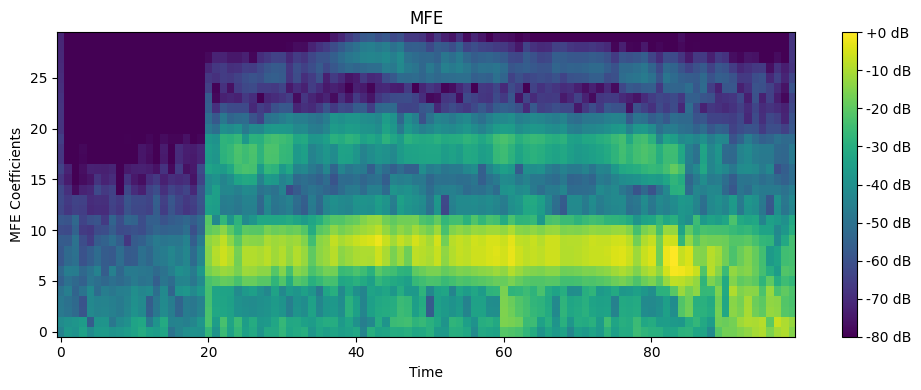

In [25]:
import matplotlib.pyplot as plt

# Lấy dữ liệu âm thanh từ df_0 hoặc df_1 (ví dụ với df_0)
data = df_0["0_0.wav"]  # Thay đổi chỉ số 0 nếu bạn muốn hiển thị dữ liệu khác

# Tính toán MFCC
mfe = convert_mel(data)
print(mfe[0].shape)
# Hiển thị biểu đồ mfe
plt.figure(figsize=(10, 4))
plt.imshow(mfe, aspect='auto', origin='lower', cmap='viridis')
plt.title('MFE')
plt.xlabel('Time')
plt.ylabel('MFE Coefficients')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [26]:
print(df_0["0_0.wav"].shape)

(44100,)


In [27]:
x = []
y = []
for i in df_0:
  data = convert_mel(df_0[i])
  x.append(np.array(data).reshape(30,100,1))
  y.append([0,1])
for i in df_1:
  data = convert_mel(df_1[i])
  x.append(np.array(data).reshape(30,100,1))
  y.append([1,0])

In [28]:
from keras.models import Sequential
from keras.layers import Conv2D,Conv1D
from keras.layers import MaxPooling2D,MaxPooling1D
from keras.layers import Dense
from keras.layers import Flatten, Activation
from keras.layers import Dropout, LSTM,Reshape, InputLayer
from keras.layers import BatchNormalization,Bidirectional, Activation,TimeDistributed,ReLU
from keras.layers import GRU
from keras.optimizers import Adam

In [29]:
from sklearn.model_selection import train_test_split
x_train, x_, y_train, y_ = train_test_split(x, y, test_size=0.4, random_state=42)
x_test,x_val,y_test,y_val = train_test_split(x_,y_,test_size=0.5,random_state=42)
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [30]:
np.shape(x_train)

(600, 30, 100, 1)

In [31]:
model = Sequential()
model.add(tf.keras.layers.Input(shape=(30,100,1)))
model.add(Conv2D(64, (4,6), activation='relu'))
model.add(Conv2D(32, (3,4), activation='relu'))
model.add(Conv2D(16, (2,2), activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D((2,4)))
model.add(Conv2D(16, (3,6), activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 27, 95, 64)     │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 92, 32)     │        24,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 91, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 91, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 22, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 10, 17, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2720)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        87,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,034 (468.88 KB)

 Trainable params: 120,034 (468.88 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
from tensorflow.keras.callbacks import Callback

class CustomEarlyStopping(Callback):
    def __init__(self, monitor='loss', threshold=0.03, patience=0):
        super(CustomEarlyStopping, self).__init__()
        self.monitor = monitor
        self.threshold = threshold
        self.patience = patience
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get(self.monitor)
        if current_loss is not None:
            if current_loss < self.threshold:
                print(f"\n{self.monitor} is below {self.threshold}, stopping training!")
                self.model.stop_training = True
        else:
            print(f"\n{self.monitor} not found in logs.")

In [33]:
model.compile(loss = 'BinaryCrossentropy',
             optimizer = Adam(learning_rate = 0.0001),
             metrics = ['accuracy'])
model.trainable = True
custom_early_stopping = CustomEarlyStopping(monitor='loss', threshold=0.02)
history = model.fit(x_train,y_train ,batch_size = 10, epochs = 100,validation_data=(x_val,y_val),callbacks=[custom_early_stopping])

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5419 - loss: 0.8868 - val_accuracy: 0.4950 - val_loss: 0.6955
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5540 - loss: 0.6809 - val_accuracy: 0.6100 - val_loss: 0.6658
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5347 - loss: 0.6953 - val_accuracy: 0.6250 - val_loss: 0.6619
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6600 - loss: 0.6519 - val_accuracy: 0.5850 - val_loss: 0.6600
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6180 - loss: 0.6607 - val_accuracy: 0.5450 - val_loss: 0.6700
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6480 - loss: 0.6428 - val_accuracy: 0.6300 - val_loss: 0.6328
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6466 - loss: 0.6234 - val_accuracy: 0.6650 - val_loss: 0.6182
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7097 - loss: 0.5916 - val_accuracy: 0.7200 -

In [34]:
model.save("model_final_mfc.keras")
# model = tf.keras.models.load_model('model_final.hb',custom_objects = {"Keraslayers": hub.KerasLayer})
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 27, 95, 64)     │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 92, 32)     │        24,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 91, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 91, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 22, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 10, 17, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2720)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        87,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 360,104 (1.37 MB)

 Trainable params: 120,034 (468.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 240,070 (937.78 KB)

In [35]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Accuracy:", test_accuracy, '\nLoss: 0.0962', )

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9687 - loss: 0.0814 
Test Accuracy: 0.9700000286102295 
Loss: 0.0962


In [36]:
y_pre = model.predict(x_val)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


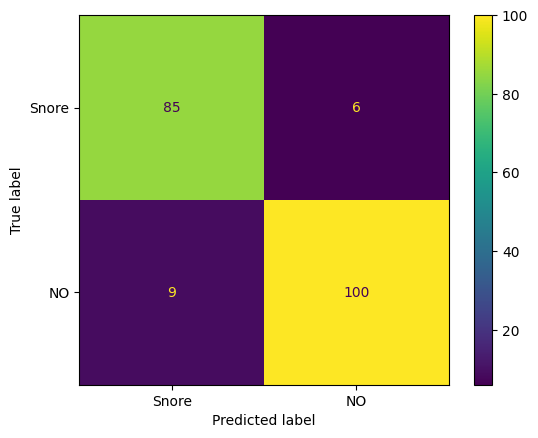

In [37]:
cm = confusion_matrix(np.argmax(y_val,axis = 1) , np.argmax(y_pre,axis = 1))
# Hiển thị ma trận nhầm lẫn với nhãn tùy chỉnh
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Snore", "NO"])
disp.plot()
plt.show()

In [38]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
def representative_dataset_generator():
    for i in range(50):
        yield [x_train[i:i+20].astype(np.float32)]  # Chuyển đổi kiểu dữ liệu và trả về một mẫu
converter.representative_dataset = representative_dataset_generator
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
converter.target_spec.supported_ops.append(tf.lite.OpsSet.SELECT_TF_OPS)
tflite_model = converter.convert()
open("mfe.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp4rs0xo0a\assets


INFO:tensorflow:Assets written to: C:\Users\Admin\AppData\Local\Temp\tmp4rs0xo0a\assets


Saved artifact at 'C:\Users\Admin\AppData\Local\Temp\tmp4rs0xo0a'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 100, 1), dtype=tf.float32, name='keras_tensor_56')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  1697933454400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1697933458800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1697933609440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1697933612432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1697933614896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1697933617184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1697933740688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1697933743680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1697933745968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1697933750192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  169

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\lite\python\convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


129400

In [39]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="./mfe.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input shape:", input_details[0]['shape'])
print("Input type:", input_details[0]['dtype'])

input_shape = input_details[0]['shape']

def tiny_predict(x_test, y_test):
    x_test = np.array(x_test, dtype=np.float32)
    count = 0
    for i in range(len(x_test)-1):
        interpreter.set_tensor(input_details[0]['index'],x_test[i:i+1])
        interpreter.invoke()
        result = interpreter.get_tensor(output_details[0]['index'])
        if np.argmax(y_test[i]) == np.argmax(result):
            count +=1
    return (count/len(x_test)*100)
print('Train accuracy (TinyML): ', tiny_predict(x_train, y_train),'%')
print('Test accuracy (TinyML): ', tiny_predict(x_val, y_val),'%')

Input shape: [  1  30 100   1]
Input type: <class 'numpy.float32'>
Train accuracy (TinyML):  99.83333333333333 %
Test accuracy (TinyML):  92.5 %
